In [3]:
# Q2
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/French.txt', 'data/names/Vietnamese.txt', 'data/names/English.txt', 'data/names/Greek.txt', 'data/names/Dutch.txt', 'data/names/German.txt', 'data/names/Irish.txt', 'data/names/Czech.txt', 'data/names/Arabic.txt', 'data/names/Russian.txt', 'data/names/Portuguese.txt', 'data/names/Chinese.txt', 'data/names/Spanish.txt', 'data/names/Korean.txt', 'data/names/Scottish.txt', 'data/names/Japanese.txt', 'data/names/Italian.txt', 'data/names/Polish.txt']
Slusarski


In [4]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [5]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [6]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [7]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9294, -2.9138, -2.8845, -2.9292, -2.8932, -2.8951, -2.7939, -2.9813,
         -2.8811, -2.9403, -2.9051, -2.8257, -2.8254, -2.7999, -2.9450, -2.9451,
         -2.9071, -2.8557]], grad_fn=<LogSoftmaxBackward0>)


In [8]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Irish', 6)


In [9]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Dutch / line = Donk
category = Portuguese / line = Castro
category = Scottish / line = Shaw
category = French / line = Pettigrew
category = Czech / line = Stluka
category = Dutch / line = Rompa
category = German / line = Schwangau
category = English / line = Patton
category = Russian / line = Liberzon
category = Korean / line = Hwang


In [10]:
criterion = nn.NLLLoss()

In [11]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [12]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 10s) 2.6564 Ropple / Dutch ✗ (English)
10000 10% (0m 22s) 2.1108 Pinheiro / Italian ✗ (Portuguese)
15000 15% (0m 33s) 3.1742 Dirchs / Greek ✗ (German)
20000 20% (0m 44s) 2.0467 Mcguire / French ✗ (Irish)
25000 25% (0m 55s) 2.0928 Tse / Vietnamese ✗ (Chinese)
30000 30% (1m 6s) 0.9612 Whelan / Irish ✓
35000 35% (1m 17s) 1.9733 Han / Chinese ✗ (Vietnamese)
40000 40% (1m 28s) 2.2006 Hojo / Korean ✗ (Japanese)
45000 45% (1m 40s) 0.2316 Kringos / Greek ✓
50000 50% (1m 51s) 0.9172 Soriano / Italian ✓
55000 55% (2m 3s) 3.2916 Borowski / Polish ✗ (Czech)
60000 60% (2m 13s) 0.1511 Poirier / French ✓
65000 65% (2m 22s) 0.6320 Ferguson / Scottish ✓
70000 70% (2m 34s) 0.8314 Jermy / English ✓
75000 75% (2m 45s) 0.6006 Ibu / Japanese ✓
80000 80% (2m 56s) 1.3242 Courtemanche / Irish ✗ (French)
85000 85% (3m 7s) 0.1574 Doan / Vietnamese ✓
90000 90% (3m 18s) 0.1826 Patselas / Greek ✓
95000 95% (3m 28s) 0.1020 Jelaev / Russian ✓
100000 100% (3m 41s) 0.6225 Maruyama / Japanese ✓


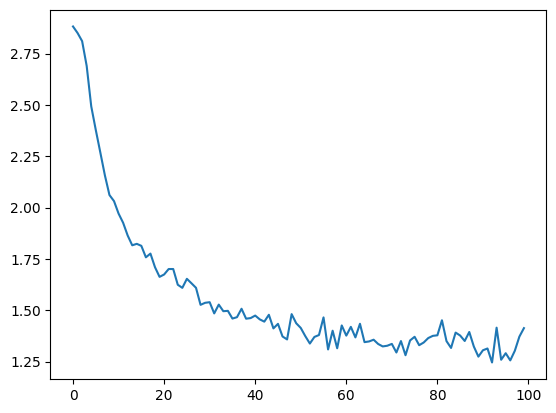

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/tmp/ipykernel_3349827/3585656379.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_3349827/3585656379.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


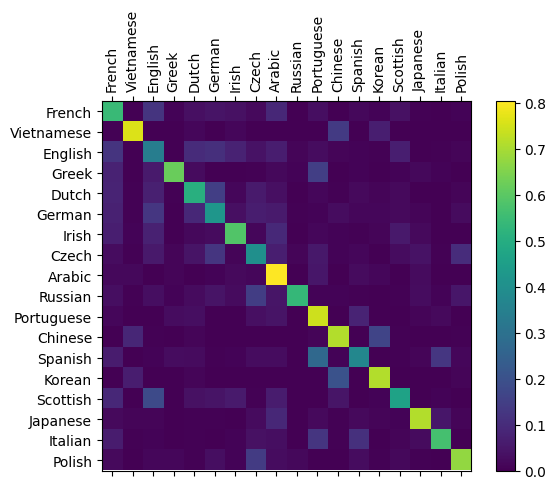

In [14]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [15]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

# predict('')
predict('Jackson')
predict('Satoshi')


> Jackson
(-0.52) Scottish
(-1.32) English
(-3.62) Czech

> Satoshi
(-1.22) Portuguese
(-1.51) Italian
(-1.69) Japanese


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import string
import random

# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        output, hidden = self.rnn(x, hidden)
        output = self.fc(output)
        return output, hidden

# Function to generate random sequence of characters
def generate_random_sequence(length):
    return ''.join(random.choices(string.ascii_lowercase, k=length))

# Function to encode a sequence of characters into one-hot vectors
def sequence_to_one_hot(sequence, vocab):
    one_hot = torch.zeros(len(sequence), len(vocab))
    for i, char in enumerate(sequence):
        one_hot[i, vocab.index(char)] = 1
    return one_hot

# Function to decode one-hot vectors back to characters
def one_hot_to_sequence(one_hot, vocab):
    indices = one_hot.argmax(dim=1)
    return ''.join([vocab[idx] for idx in indices])

In [20]:
# Define the vocabulary (lowercase English alphabets)
vocab = string.ascii_lowercase
input_size = len(vocab)
hidden_size = 128
output_size = len(vocab)
seq_len = 10  # Length of input sequences
learning_rate = 0.005
num_epochs = 1000

# Initialize the RNN model
model = RNN(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [21]:
# Train the model
for epoch in range(num_epochs):
    input_data = "hellohowareyouhopeyouaredoinggreat"  # Modified input data
    target_data = input_data[1:] + input_data[0]  # Shifted by one character for next character prediction
    input_one_hot = sequence_to_one_hot(input_data, vocab)
    target_indices = torch.tensor([vocab.index(c) for c in target_data])

    optimizer.zero_grad()
    hidden = torch.zeros(1, 1, hidden_size)  # Initialize hidden state

    output, _ = model(input_one_hot.unsqueeze(0), hidden)
    loss = criterion(output.squeeze(0), target_indices)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

Epoch [100/1000], Loss: 0.002405585255473852
Epoch [200/1000], Loss: 0.0010455482406541705
Epoch [300/1000], Loss: 0.0005994274979457259
Epoch [400/1000], Loss: 0.0003931939718313515
Epoch [500/1000], Loss: 0.0002798022178467363
Epoch [600/1000], Loss: 0.00021019783162046224
Epoch [700/1000], Loss: 0.00016412326658610255
Epoch [800/1000], Loss: 0.00013191974721848965
Epoch [900/1000], Loss: 0.00010841890616575256
Epoch [1000/1000], Loss: 9.073659748537466e-05


In [22]:
# Test the trained model by generating text
with torch.no_grad():
    # Start with a seed sequence
    seed_sequence = "hellohowareyo"  # Modified seed sequence
    print(f'Seed Sequence: {seed_sequence}')

    # Generate next characters iteratively
    generated_sequence = seed_sequence
    hidden = torch.zeros(1, 1, hidden_size)
    for _ in range(100):
        input_one_hot = sequence_to_one_hot(generated_sequence[-1], vocab)
        output, hidden = model(input_one_hot.unsqueeze(0), hidden)
        next_char = one_hot_to_sequence(output.squeeze(0), vocab)
        generated_sequence += next_char

    print(f'Generated Sequence: {generated_sequence}')

Seed Sequence: hellohowareyo
Generated Sequence: hellohowareyoelohowareyouhopeyouaredoinggreathyouaredoinggreathooueapeyouaredoinggreathyouaredoinggreathooueapeyo
